
=== Comparison Summary ===
Implicit Euler + Fixed-Point
  steps=400, h=0.5
  runtime=0.0069s
  avg_iters/step=8.28, max_iters=11
  failed_steps=0
  T_end=-13.2500, x_end=1.0000

Implicit Euler + Newton–Gauss–Seidel
  steps=400, h=0.5
  runtime=0.0034s
  avg_iters/step=2.74, max_iters=5
  failed_steps=0
  T_end=-13.2500, x_end=1.0000



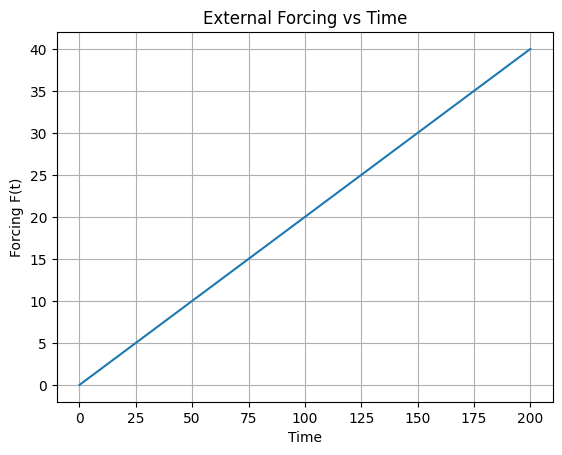

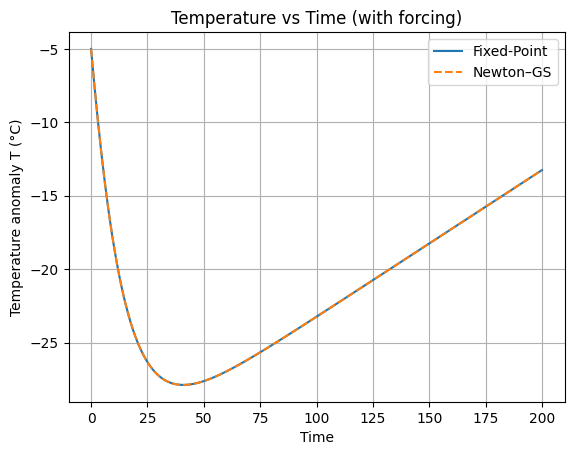

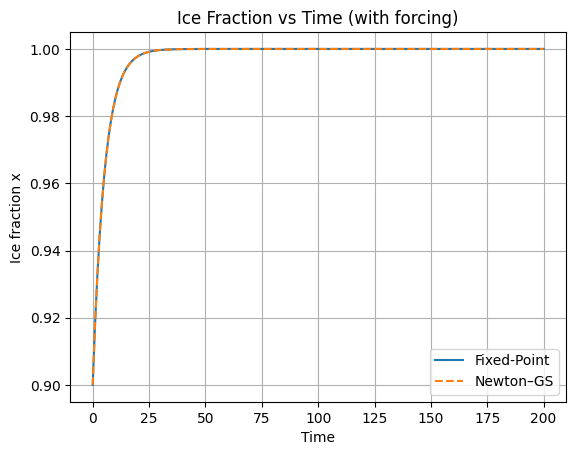

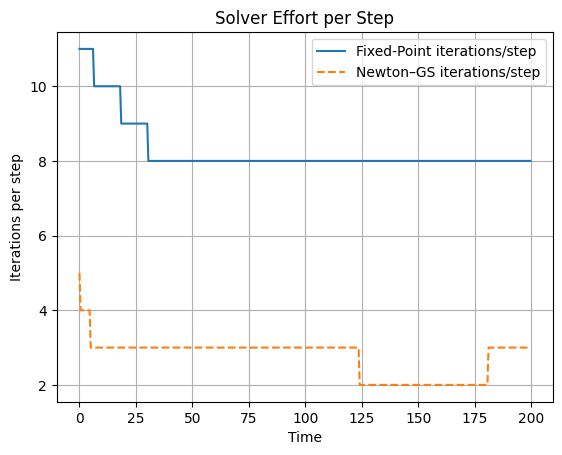

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Forcing F(t): choose one
def forcing_step(t, F0=0.0, F1=30.0, t_step=50.0):
    """
    Step forcing:
      F(t) = F0 for t < t_step
      F(t) = F1 for t >= t_step
    """
    return F0 if t < t_step else F1

def forcing_ramp(t, F_start=0.0, ramp_rate=0.2, F_max=40.0):
    """
    Ramp forcing (slow increase, capped):
      F(t) = min(F_start + ramp_rate*t, F_max)
    """
    return min(F_start + ramp_rate * t, F_max)

# Model functions
def x_eq(T, Tm, w):
    # Ice equilibrium fraction: high when cold, low when warm
    return 1.0 / (1.0 + np.exp((T - Tm) / w))

def albedo(x, a_ocean, a_ice):
    return a_ocean + (a_ice - a_ocean) * x

# Temperature RHS with forcing:
# dT/dt = (S*(1-alpha(x)) - (A + B*T) + F(t)) / tau_T
def F_T(T, x, t, p):
    a = albedo(x, p["alpha_ocean"], p["alpha_ice"])
    F = p["forcing"](t)  # external forcing function
    return (p["S"] * (1.0 - a) - (p["A"] + p["B"] * T) + F) / p["tau_T"]

# Ice RHS:
# dx/dt = (x_eq(T) - x)/tau_x
def F_x(T, x, p):
    return (x_eq(T, p["Tm"], p["w"]) - x) / p["tau_x"]

# One implicit Euler step: Fixed-Point Iteration
def step_fixed_point(Tn, xn, tn, h, p, max_iter=200, tol=1e-10):
    T = Tn
    x = xn
    for it in range(1, max_iter + 1):
        Told, xold = T, x

        # Fixed-point map for implicit Euler:
        T = Tn + h * F_T(T, x, tn + h, p)  # use t_{n+1}
        x = xn + h * F_x(T, x, p)          # coupled through updated T

        x = min(1.0, max(0.0, x))
        err = max(abs(T - Told), abs(x - xold))
        if err < tol:
            return T, x, it, True
    return T, x, max_iter, False

# One implicit Euler step: Newton–Gauss–Seidel
def step_newton_gs(Tn, xn, tn, h, p, max_iter=50, tol=1e-12):
    """
    Solve:
      R1(T,x)= T - Tn - h*F_T(T,x,t_{n+1}) = 0
      R2(T,x)= x - xn - h*F_x(T,x)        = 0
    via Newton updates in Gauss–Seidel style.
    """
    T = Tn
    x = xn
    tnp1 = tn + h

    for it in range(1, max_iter + 1):
        Told, xold = T, x

        # Update T (Newton 1D with x fixed)
        # F_T depends linearly on T through -(B*T)/tau_T
        # dF_T/dT = -(B/tau_T)
        dF_dT = -(p["B"] / p["tau_T"])
        dR1_dT = 1.0 - h * dF_dT  # = 1 + h*(B/tau_T)

        R1 = T - Tn - h * F_T(T, x, tnp1, p)
        T = T - R1 / dR1_dT

        # Update x (Newton 1D with updated T fixed) 
        # R2 = x - xn - h*(x_eq(T)-x)/tau_x
        # dR2/dx = 1 + h/tau_x
        R2 = x - xn - h * F_x(T, x, p)
        dR2_dx = 1.0 + (h / p["tau_x"])
        x = x - R2 / dR2_dx

        x = min(1.0, max(0.0, x))

        err = max(abs(T - Told), abs(x - xold))
        if err < tol:
            return T, x, it, True

    return T, x, max_iter, False

# Simulation wrapper
def simulate(stepper, name, t0, t1, h, T0, x0, p):
    N = int(np.ceil((t1 - t0) / h))
    t = np.linspace(t0, t0 + N * h, N + 1)

    T = np.zeros(N + 1)
    x = np.zeros(N + 1)
    iters = np.zeros(N, dtype=int)
    ok = np.zeros(N, dtype=bool)

    T[0] = T0
    x[0] = x0

    start = time.perf_counter()
    for n in range(N):
        T[n + 1], x[n + 1], iters[n], ok[n] = stepper(T[n], x[n], t[n], h, p)
    elapsed = time.perf_counter() - start

    summary = {
        "method": name,
        "steps": N,
        "h": h,
        "runtime_sec": elapsed,
        "avg_iters": float(np.mean(iters)),
        "max_iters": int(np.max(iters)),
        "failed_steps": int(np.sum(~ok)),
        "T_end": float(T[-1]),
        "x_end": float(x[-1]),
    }
    return t, T, x, iters, summary


if __name__ == "__main__":
    # Parameters
    p = {
        "alpha_ocean": 0.30,
        "alpha_ice": 0.60,

        "S": 340.0,
        "A": 200.0,
        "B": 2.0,

        "tau_T": 25.0,
        "tau_x": 5.0,

        "Tm": 0.0,
        "w": 0.6,

    

        # ramp forcing (default)
        "forcing": lambda t: forcing_ramp(t, F_start=0.0, ramp_rate=0.2, F_max=40.0),
    }

    # Simulation settings
    t0, t1 = 0.0, 200.0
    h = 0.5

    # Initial conditions
    T0 = -5.0
    x0 = 0.9

    # Run both solvers
    t_fp, T_fp, x_fp, it_fp, sum_fp = simulate(
        step_fixed_point, "Implicit Euler + Fixed-Point", t0, t1, h, T0, x0, p
    )
    t_ngs, T_ngs, x_ngs, it_ngs, sum_ngs = simulate(
        step_newton_gs, "Implicit Euler + Newton–Gauss–Seidel", t0, t1, h, T0, x0, p
    )

    # Print comparison summary
    print("\n=== Comparison Summary ===")
    for s in (sum_fp, sum_ngs):
        print(
            f"{s['method']}\n"
            f"  steps={s['steps']}, h={s['h']}\n"
            f"  runtime={s['runtime_sec']:.4f}s\n"
            f"  avg_iters/step={s['avg_iters']:.2f}, max_iters={s['max_iters']}\n"
            f"  failed_steps={s['failed_steps']}\n"
            f"  T_end={s['T_end']:.4f}, x_end={s['x_end']:.4f}\n"
        )

    # Plot forcing for clarity
    F_vals = np.array([p["forcing"](ti) for ti in t_fp])

    plt.figure()
    plt.plot(t_fp, F_vals)
    plt.xlabel("Time")
    plt.ylabel("Forcing F(t)")
    plt.title("External Forcing vs Time")
    plt.grid(True)

    plt.figure()
    plt.plot(t_fp, T_fp, label="Fixed-Point")
    plt.plot(t_ngs, T_ngs, label="Newton–GS", linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("Temperature anomaly T (°C)")
    plt.title("Temperature vs Time (with forcing)")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_fp, x_fp, label="Fixed-Point")
    plt.plot(t_ngs, x_ngs, label="Newton–GS", linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("Ice fraction x")
    plt.title("Ice Fraction vs Time (with forcing)")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_fp[:-1], it_fp, label="Fixed-Point iterations/step")
    plt.plot(t_ngs[:-1], it_ngs, label="Newton–GS iterations/step", linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("Iterations per step")
    plt.title("Solver Effort per Step")
    plt.grid(True)
    plt.legend()

    plt.show()
